In [42]:
!pip install tensorflow matplotlib numpy pillow

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [140]:
from google.colab import drive
drive.mount('/content/drive')

# Path ke dataset
data_dir = '/content/drive/MyDrive/path_to_dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
def build_generator(latent_dim):
    model = models.Sequential([
        layers.Dense(4 * 4 * 256, input_dim=latent_dim),
        layers.Reshape((4, 4, 256)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same", activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh")
    ])
    return model


In [81]:
def build_discriminator(img_shape):
    model = models.Sequential([
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=img_shape),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

In [82]:
img_shape = (64, 64, 3)
discriminator = build_discriminator(img_shape)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


# Bagian Baru

In [89]:
def build_gan(generator, discriminator):
    # Discriminator tidak dilatih selama pelatihan GAN
    discriminator.trainable = False

    # Input untuk GAN
    gan_input = layers.Input(shape=(latent_dim,))

    # Generator menghasilkan gambar dari input noise
    generated_image = generator(gan_input)

    # Discriminator mengevaluasi gambar yang dihasilkan
    gan_output = discriminator(generated_image)

    # Kombinasikan Generator dan Discriminator
    gan = models.Model(gan_input, gan_output)
    gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')
    return gan

    # Pastikan `generator` dan `discriminator` sudah dibuat sebelumnya
    gan = build_gan(generator, discriminator)
    gan.summary()


In [103]:
from PIL import Image  # Impor dengan benar

def preprocess_images(data_dir, img_size=(64, 64)):
    images = []
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)
        img = Image.open(img_path).resize(img_size).convert("RGB")  # Gunakan Image.open
        images.append(np.asarray(img) / 127.5 - 1)  # Normalize to [-1, 1]
    return np.array(images)

# Contoh pemanggilan fungsi
anime_images = preprocess_images(data_dir)
print(f"Dataset size: {anime_images.shape}")


Dataset size: (118, 64, 64, 3)


In [90]:
latent_dim = 100
generator = build_generator(latent_dim)

# Generate a sample image
noise = np.random.normal(0, 1, (1, latent_dim))
generated_image = generator.predict(noise)
print(f"Generated image shape: {generated_image.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Generated image shape: (1, 64, 64, 3)


In [145]:
def train_dcgan(generator, discriminator, gan, images, latent_dim, epochs, batch_size):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, images.shape[0], half_batch)
        real_imgs = images[idx]
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Display progress
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}/{epochs} | D Loss: {d_loss[0]} | G Loss: {g_loss}")
            save_generated_images(generator, latent_dim, epoch)

def save_generated_images(generator, latent_dim, epoch, examples=25, dim=(5, 5), figsize=(10, 10)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = (generated_images + 1) / 2.0  # Rescale to [0, 1] for visualization
    fig, axs = plt.subplots(dim[0], dim[1], figsize=figsize)
    cnt = 0
    for i in range(dim[0]):
        for j in range(dim[1]):
            axs[i, j].imshow(generated_images[cnt])
            axs[i, j].axis('off')
            cnt += 1
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()


In [116]:
latent_dim = 100
img_shape = (64, 64, 3)

generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape)
gan = build_gan(generator, discriminator)

train_dcgan=(generator, discriminator, gan, anime_images, latent_dim, epochs, batch_size)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [144]:
from PIL import Image
import numpy as np

generated_image = np.random.rand(64, 64, 3) * 255  # Contoh gambar acak
generated_image = generated_image.astype(np.uint8)  # Ubah ke tipe data uint8

pil_image = Image.fromarray(generated_image)

epoch = 100
pil_image.save(f'generated_images_epoch_{epoch}.png')

['98_2000.jpg', '97_2000.jpg', '96_2000.jpg', '94_2000.jpg', '99_2000.jpg', '92_2000.jpg', '93_2000.jpg', '9_2000.jpg', '88_2000.jpg', '90_2000.jpg', '95_2000.jpg', '8_2000.jpg', '89_2000.jpg', '91_2000.jpg', '911_2000.jpg', '929_2000.jpg', '930_2000.jpg', '922_2000.jpg', '937_2000.jpg', '926_2000.jpg', '921_2000.jpg', '925_2000.jpg', '924_2000.jpg', '928_2000.jpg', '927_2000.jpg', '920_2000.jpg', '923_2000.jpg', '910_2000.jpg', '918_2000.jpg', '917_2000.jpg', '912_2000.jpg', '916_2000.jpg', '919_2000.jpg', '915_2000.jpg', '913_2000.jpg', '914_2000.jpg', '965_2000.jpg', '978_2000.jpg', '968_2000.jpg', '959_2000.jpg', '957_2000.jpg', '955_2000.jpg', '951_2000.jpg', '950_2000.jpg', '958_2000.jpg', '956_2000.jpg', '979_2000.jpg', '969_2000.jpg', '954_2000.jpg', '952_2000.jpg', '971_2000.jpg', '972_2000.jpg', '975_2000.jpg', '974_2000.jpg', '973_2000.jpg', '970_2000.jpg', '976_2000.jpg', '953_2000.jpg', '966_2000.jpg', '960_2000.jpg', '962_2000.jpg', '963_2000.jpg', '961_2000.jpg', '967_20

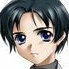

In [160]:
from PIL import Image
from IPython.display import display
import os

directory = '/content/drive/MyDrive/path_to_dataset'

files = os.listdir(directory)
print(files)  # Lihat daftar file di direktori

image_filename = '993_2000.jpg'
img_path = os.path.join(directory, image_filename)

img = Image.open(img_path)
display(img)


